# Practical 1.2 - Iris Flower Classificiation
## Introduction
In this practical we focus on training classification machine learning models.

There are two major types of supervised learning
1. Regression - predicting a value given some input
2. Classification - predicting the class/label given some input

In this practical we focus on classification, specifically classifying different species of Iris flowers:

<div class="container" style="text-align: center;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/Iris_versicolor_3.jpg/800px-Iris_versicolor_3.jpg" width="200"/>
    <h4> Iris Versicolor </h4>
</div>

based on attributes or characteristics of the flowers:
- Sepal Length
- Sepal Width
- Petal Width
- Petal Length

> In machine learning/data science, we call these characteristics features

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score

from mlutils.plot import plot_2d_decison_bounds

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Sourcing data
Thankfully, the Iris dataset is built into Scikit-learn, making loading it incredibly easy:

In [2]:
iris_data = datasets.load_iris()
features, species = iris_data["data"], iris_data["target"]

In [3]:
print(f"{len(features)} examples, {len(np.unique(species))} classes/labels in the dataset")

150 examples, 3 classes/labels in the dataset


# Single Feature Models

## Prepare data
To reiterate the problem: our model has to correctly classify the species given an input feature - in this case we will try using the petal length:


In [4]:
# find the position of the petal features in features list
petal_len_pos = iris_data["feature_names"].index("petal length (cm)")
# extract out petal length feature
petal_lens = features[:, petal_len_pos]

To be able to evalaute the model after training, we set aside some data that the model will not see during training, so that we can determine the models performance on **unseen data**. The data that we set aside is called the **validation set**

> Why do we need to shuffle before splitting?
> ANS: To ensure that the data in the resulting training and validation sets are not skewed in some way

We set aside a validation set as follows:

In [5]:
# Shuffle than split the data into train and validate subsets
train_petal_lens, valid_petal_lens, train_species, valid_species = train_test_split(
    petal_lens.reshape((-1, 1)), species, test_size=0.3, shuffle=True, random_state=0)

> Why do we need the weird `reshape(...)` call?
> This is because scikit-learn expects data in the 'shape' `[example, feature]`. 
> Our `train_petal_lens` has only one feature (petal length) hence its 'shape' is `[example]`. We change it `[example, 1]` to fullfill the `[example, feature]` criteria

## Training the Model
We preceed to train a simple logistic regression model on the data. This is quite elementary.

In [6]:
model= LogisticRegression(multi_class="ovr", solver="lbfgs", penalty='none')
model.fit(train_petal_lens.reshape(-1,1), train_species)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Evaluating the Model
Now that we have a model, we have to evaluate it see how well its doing.

We covered 3 ways to do this is the lecture:
1. plotting the model with the to visually examine it
   - we can't do this yet because it requires at least two features to do. In this case we only trained the mode on one feature
2. Evaluating the model on a metric
3. Evaluating the model with a learning curve


### Evaluating the model on a loss function.
We need a yardstick to help us evaluate if the model is doing well. This yardstick is called the **metric**. 

We can use the **loss function** as a metric which uses complicated math to compute a number called the **loss** which tells us numerically how we are doing. Generally a smaller **loss** means a better model.

However, loss values are not very interpretable (ie is `2.456527248e+2` a good value or bad value?). This calls more interpretable metrics like **accuracy** which is basically the percentage of examples the model classified correctly (ie 68% correct at classifying is way more interpretable). Obviously, the higher the accuracy, the better the model.

 The accuracy evaluated on the training set is called the **training accuracy**, while the loss evaluated the validation set is called **validation accuracy**
 - the higher the training accuracy the better the model is at fitting the training data
 - the higher the validation accuracy, the better model is at generalising to unseen data

#### Training Accuracy
Computing training accuracy is simple:
- use the model to compute predictions on the training data
- compute accuracy on the predictions

In [7]:
train_preds = model.predict(train_petal_lens)
print(f"training accuracy: {accuracy_score(train_species, train_preds) * 100.0}%")

training accuracy: 95.23809523809523%


#### Validation Accuracy
We cross validate the model on the validation set by:
- using the model to compute predictions on the validation data
- computing accuracy on the prediction

> This is important as it allow us to determine if the model actually learnt something, not memorising everything

In [8]:
valid_preds = model.predict(valid_petal_lens)
print(f"validation accuracy: {accuracy_score(valid_species, valid_preds) * 100.0}%")

validation accuracy: 95.55555555555556%


### Evaluating using a Learning Curve
The learning curve is instrumental tool for training models, because it helps combat 2 of the biggest problems when do machine learning **overfitting** (_high variance_) and **underfitting**(_high bias_). It tells us how to improve the model.

To plot a learning curve, we train models with increasing amounts of training data and plot the accuarcy:
```python
valid_accs = []
train_accs = []

train_percents = [10, 33, 55, 78, 1]
for train_percent in train_percents:
    # train the model on increasing amounts of data
    n_train = (train_percent / 100.0) * len(train_petal_lens)
    model = LogisticRegression()
    model.fit(train_petal_lens[:n_train], train_species[:n_train])
    
    # evaluate model training and validation accuracy
    train_preds = model.predict(train_petal_lens)
    train_accs.append(accuracy_score(train_species, train_preds) * 100.0)
    valid_preds = model.predict(valid_petal_lens)
    valid_accs.append(accuracy_score(valid_species, valid_preds) * 100.0)
    
# plot the learning curve
plt.title("Learning Curve")
plt.xlabel("% training data")
plt.ylabel("accuracy")
plt.plot(train_percents, train_accs, label="Training")
plt.plot(train_percents, valid_accs, label="Validation")
plt.legend()
plt.show()
```

But we run into a problem, because we have very little data, we get different graphs every
time we evaluate.
Thankfully scikit-learn provides a `learning_curve(...)` learning curve that does not change much.
> It does this computing multiple learning curves, we will average them to get a steady learning curve

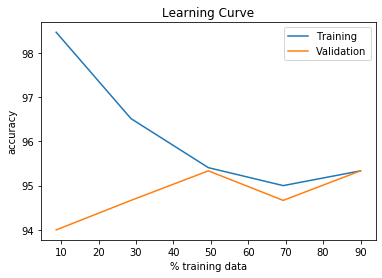

In [9]:
n_total_train = len(petal_lens)
# compute learning curve stats
model = LogisticRegression(multi_class="ovr", solver="lbfgs", penalty='none')

def plot_learning_curve(model, inputs, outputs):
    # computes 10 learning curves stats
    n_trains, train_accs_kfold, valid_accs_kfold = learning_curve(
    model, inputs, outputs, cv=10, scoring="accuracy", shuffle=True, 
        random_state=0)

    # compute average learning curve stats
    train_percents = 100 * (n_trains /  n_total_train)
    train_accs = 100 * np.mean(train_accs_kfold, axis=-1)
    valid_accs = 100 * np.mean(valid_accs_kfold, axis=-1)

    # plot the learning curve
    plt.title("Learning Curve")
    plt.xlabel("% training data")
    plt.ylabel("accuracy")
    plt.plot(train_percents, train_accs, label="Training")
    plt.plot(train_percents, valid_accs, label="Validation")
    plt.legend()
    plt.show()

plot_learning_curve(model, petal_lens.reshape((-1, 1)), species)

From the curve we can observe that the model giving good performance (>95% accuracy). However, there is space for improvement: it also points us in the direction of how to improve the model. 

Both the validation and training accuracy are close together. This means that the model is slightly underfitting.

# Iterate. Iterate. Iterate.
Now that we have diagnosed problems with the model is slightly underfitting we can try solutions to underfitting/high bias:
- training with more features
- training with a more powerful model
In this practical we will use a better model to 

## Building the better model
Lets try both solutions at the same time.
- When training the first model, we only used one feature: the petal length. Lets try training the model with all the features.
- Additonally we use a more powerful model: A `RandomForestClassifier`

training accuracy: 99.04761904761905%
validation accuracy: 97.77777777777777%


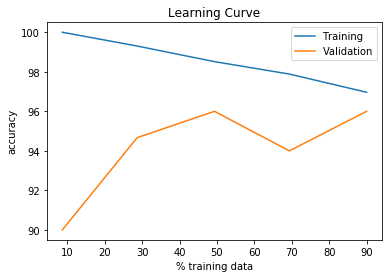

In [10]:
# Prepare the data: split train validation set
train_features, valid_features, train_species, valid_species = train_test_split(
    features, species, test_size=0.3, shuffle=True, random_state=0)

# Train the model
model = RandomForestClassifier(n_estimators=32, max_depth=4, random_state=0)
model.fit(train_features, train_species)

# Evaluate the model: accuracy metric 
train_preds = model.predict(train_features)
print(f"training accuracy: {accuracy_score(train_species, train_preds) * 100.0}%")

valid_preds = model.predict(valid_features)
print(f"validation accuracy: {accuracy_score(valid_species, valid_preds) * 100.0}%")

# Evaluate the model: learning curve
model = RandomForestClassifier(n_estimators=42, max_depth=3)
plot_learning_curve(model, features, species)